In [1]:
import os
import ast
import math
import random
import numpy as np
import pandas as pd
from numpy import std
from numpy import nan
from numpy import mean
from scipy.spatial import distance

In [2]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [3]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV as GA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get Data

In [4]:
patients_full = pd.read_csv('patients.csv')
patients_full

rno  Visite_day  heathrate_min  heathrate_max  \
0     Ta-01-0001-3  2017-01-26           52.5          114.5   
1     Ta-01-0001-3  2017-01-27           56.0          110.0   
2     Ta-01-0001-3  2017-01-28           56.0           86.0   
3     Ta-01-0001-3  2017-01-29           46.0           94.0   
4     Ta-01-0001-3  2017-01-30           40.0          115.0   
...            ...         ...            ...            ...   
2381  Ta-16-0002-8  2019-08-05           61.0           74.0   
2382  Ta-16-0002-8  2019-08-06           67.0           77.0   
2383  Ta-16-0002-8  2019-08-07           61.0           72.0   
2384  Ta-16-0002-8  2019-08-08           64.0           71.0   
2385  Ta-16-0002-8  2019-08-09           52.0           78.0   

      blood_pressure_min  blood_pressure_max  mean_art.bloodpressure_min  \
0                   63.0               121.0                        55.0   
1                   63.0               121.0                        64.0   
2                   63.0               121.0                        69.0   
3                   63.0               121.0                        59.0   
4                   63.0               121.0                        63.0   
...                  ...                 ...                         ...   
2381                75.0               187.0                        51.0   
2382                75.0               187.0                        57.0   
2383                75.0               187.0                        54.0   
2384                75.0               187.0                        64.0   
2385                75.0               187.0                        34.0   

      mean_art.bloodpressure_max  temp_min  temp_max  ...  \
0                           84.5      33.4      37.6  ...   
1                           81.0      35.4      38.5  ...   
2                           86.0      35.7      37.0  ...   
3                           81.0      36.5      38.3  ...   
4                           95.0      34.5      37.1  ...   
...                          ...       ...       ...  ...   
2381                       106.0      36.6      37.6  ...   
2382                        86.0      36.9      37.8  ...   
2383                        90.0      37.4      37.7  ...   
2384                        92.0      38.0      38.0  ...   
2385                       104.0      38.0      38.0  ...   

      pip_resistance_503(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                     0                         
1                                                     0                         
2                                                     0                         
3                                                     0                         
4                                                     0                         
...                                                 ...                         
2381                                                  0                         
2382                                                  0                         
2383                                                  0                         
2384                                                  0                         
2385                                                  0                         

      pip_resistance_504(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                     0                         
1                                                     0                         
2                                                     0                         
3                                                     0                         
4                                                     0                         
...                                                 ...                         
2381                                                  0     

Here, all the sofa scores that are above 16 will be dropped

In [5]:
patients_reduced = patients_full.drop(patients_full[patients_full.Sofa > 16].index)
patients_reduced = patients_reduced.reset_index(drop=True)
patients_reduced

rno  Visite_day  heathrate_min  heathrate_max  \
0     Ta-01-0001-3  2017-01-26           52.5          114.5   
1     Ta-01-0001-3  2017-01-27           56.0          110.0   
2     Ta-01-0001-3  2017-01-28           56.0           86.0   
3     Ta-01-0001-3  2017-01-29           46.0           94.0   
4     Ta-01-0001-3  2017-01-30           40.0          115.0   
...            ...         ...            ...            ...   
2336  Ta-16-0002-8  2019-08-05           61.0           74.0   
2337  Ta-16-0002-8  2019-08-06           67.0           77.0   
2338  Ta-16-0002-8  2019-08-07           61.0           72.0   
2339  Ta-16-0002-8  2019-08-08           64.0           71.0   
2340  Ta-16-0002-8  2019-08-09           52.0           78.0   

      blood_pressure_min  blood_pressure_max  mean_art.bloodpressure_min  \
0                   63.0               121.0                        55.0   
1                   63.0               121.0                        64.0   
2                   63.0               121.0                        69.0   
3                   63.0               121.0                        59.0   
4                   63.0               121.0                        63.0   
...                  ...                 ...                         ...   
2336                75.0               187.0                        51.0   
2337                75.0               187.0                        57.0   
2338                75.0               187.0                        54.0   
2339                75.0               187.0                        64.0   
2340                75.0               187.0                        34.0   

      mean_art.bloodpressure_max  temp_min  temp_max  ...  \
0                           84.5      33.4      37.6  ...   
1                           81.0      35.4      38.5  ...   
2                           86.0      35.7      37.0  ...   
3                           81.0      36.5      38.3  ...   
4                           95.0      34.5      37.1  ...   
...                          ...       ...       ...  ...   
2336                       106.0      36.6      37.6  ...   
2337                        86.0      36.9      37.8  ...   
2338                        90.0      37.4      37.7  ...   
2339                        92.0      38.0      38.0  ...   
2340                       104.0      38.0      38.0  ...   

      pip_resistance_503(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                     0                         
1                                                     0                         
2                                                     0                         
3                                                     0                         
4                                                     0                         
...                                                 ...                         
2336                                                  0                         
2337                                                  0                         
2338                                                  0                         
2339                                                  0                         
2340                                                  0                         

      pip_resistance_504(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                     0                         
1                                                     0                         
2                                                     0                         
3                                                     0                         
4                                                     0                         
...                                                 ...                         
2336                                                  0     

In [6]:
grouped = patients_reduced.groupby('rno')
dfs = []
for name, group in grouped:
    dfs.append(group.copy())

In [7]:
dfs_origin = []
for df_ in dfs:
    if any(df_['Sofa'].isin([0, 1])):
        dfs_origin.append(df_)

In [8]:
df_origin = pd.concat(dfs_origin, ignore_index=True)

In [9]:
origin_TDM = []
origin_CON = []
for df_ in dfs_origin:
    if 1 in df_['Randomization group (1_TDM 2_Control)'].unique():
        origin_TDM.append(df_)
    elif 2 in df_['Randomization group (1_TDM 2_Control)'].unique():
        origin_CON.append(df_)
origin_TDM_selected = random.sample(origin_TDM, 5)
origin_CON_selected = random.sample(origin_CON, 5)

In [10]:
df_origin_TDM_sel = pd.concat(origin_TDM_selected, ignore_index=True)
df_origin_CON_sel = pd.concat(origin_CON_selected, ignore_index=True)

In [11]:
df_origin_TDM_sel.to_csv('5_TDM_origin.csv', index=False)
df_origin_CON_sel.to_csv('5_CON_origin.csv', index=False)

In [12]:
rno_list = df_origin_TDM_sel['rno'].tolist()
mask = df_origin['rno'].isin(rno_list)
df_origin2 = df_origin[~mask]

In [13]:
rno_list = df_origin_CON_sel['rno'].tolist()
mask = df_origin2['rno'].isin(rno_list)
df_origin3 = df_origin2[~mask]

In [18]:
len(dfs_origin)

26

In [15]:
df_origin

rno  Visite_day  heathrate_min  heathrate_max  \
0    Ta-01-0010-3  2017-06-26           81.0          125.0   
1    Ta-01-0010-3  2017-06-27           68.0           85.0   
2    Ta-01-0010-3  2017-06-28           70.0           85.0   
3    Ta-01-0010-3  2017-06-29           60.0           81.0   
4    Ta-01-0010-3  2017-06-30           57.0           94.0   
..            ...         ...            ...            ...   
234  Ta-13-0001-7  2017-07-21           58.0           88.0   
235  Ta-13-0001-7  2017-07-22           68.0           98.0   
236  Ta-13-0001-7  2017-07-23           62.0          100.0   
237  Ta-13-0001-7  2017-07-24           60.0           82.0   
238  Ta-13-0001-7  2017-07-25           70.0           78.0   

     blood_pressure_min  blood_pressure_max  mean_art.bloodpressure_min  \
0                  76.0               133.0                        62.0   
1                  76.0               133.0                        68.0   
2                  76.0               133.0                        77.0   
3                  76.0               133.0                        70.0   
4                  76.0               133.0                        64.0   
..                  ...                 ...                         ...   
234                70.0               155.0                        71.7   
235                70.0               155.0                        73.3   
236                70.0               155.0                        57.3   
237                70.0               155.0                        80.0   
238                70.0               155.0                        73.3   

     mean_art.bloodpressure_max  temp_min  temp_max  ...  \
0                          86.5      37.3      38.5  ...   
1                          96.0      37.2      37.6  ...   
2                          99.0      37.4      37.6  ...   
3                         101.0      37.1      37.6  ...   
4                         101.0      36.9      37.3  ...   
..                          ...       ...       ...  ...   
234                       115.0      36.5      37.2  ...   
235                       100.0      35.3      36.7  ...   
236                       120.0      35.8      35.9  ...   
237                        99.3      35.8      35.8  ...   
238                        95.0      35.8      35.8  ...   

     pip_resistance_503(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                    0                         
1                                                    0                         
2                                                    0                         
3                                                    0                         
4                                                    0                         
..                                                 ...                         
234                                                  0                         
235                                                  0                         
236                                                  0                         
237                                                  0                         
238                                                  0                         

     pip_resistance_504(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                    0                         
1                                                    0                         
2                                                    0                         
3                                                    0                         
4                                                    0                         
..                                                 ...                         
234                                                  0                         
235                               

In [17]:
df_origin3

rno  Visite_day  heathrate_min  heathrate_max  \
0    Ta-01-0010-3  2017-06-26           81.0          125.0   
1    Ta-01-0010-3  2017-06-27           68.0           85.0   
2    Ta-01-0010-3  2017-06-28           70.0           85.0   
3    Ta-01-0010-3  2017-06-29           60.0           81.0   
4    Ta-01-0010-3  2017-06-30           57.0           94.0   
..            ...         ...            ...            ...   
234  Ta-13-0001-7  2017-07-21           58.0           88.0   
235  Ta-13-0001-7  2017-07-22           68.0           98.0   
236  Ta-13-0001-7  2017-07-23           62.0          100.0   
237  Ta-13-0001-7  2017-07-24           60.0           82.0   
238  Ta-13-0001-7  2017-07-25           70.0           78.0   

     blood_pressure_min  blood_pressure_max  mean_art.bloodpressure_min  \
0                  76.0               133.0                        62.0   
1                  76.0               133.0                        68.0   
2                  76.0               133.0                        77.0   
3                  76.0               133.0                        70.0   
4                  76.0               133.0                        64.0   
..                  ...                 ...                         ...   
234                70.0               155.0                        71.7   
235                70.0               155.0                        73.3   
236                70.0               155.0                        57.3   
237                70.0               155.0                        80.0   
238                70.0               155.0                        73.3   

     mean_art.bloodpressure_max  temp_min  temp_max  ...  \
0                          86.5      37.3      38.5  ...   
1                          96.0      37.2      37.6  ...   
2                          99.0      37.4      37.6  ...   
3                         101.0      37.1      37.6  ...   
4                         101.0      36.9      37.3  ...   
..                          ...       ...       ...  ...   
234                       115.0      36.5      37.2  ...   
235                       100.0      35.3      36.7  ...   
236                       120.0      35.8      35.9  ...   
237                        99.3      35.8      35.8  ...   
238                        95.0      35.8      35.8  ...   

     pip_resistance_503(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                    0                         
1                                                    0                         
2                                                    0                         
3                                                    0                         
4                                                    0                         
..                                                 ...                         
234                                                  0                         
235                                                  0                         
236                                                  0                         
237                                                  0                         
238                                                  0                         

     pip_resistance_504(1:sensitive-2:intermediate-3:resistant-9:not_tested)  \
0                                                    0                         
1                                                    0                         
2                                                    0                         
3                                                    0                         
4                                                    0                         
..                                                 ...                         
234                                                  0                         
235                               

In [14]:
df_origin3.to_csv('origin.csv', index=False)

In [15]:
rno_list = df_origin_TDM_sel['rno'].tolist()
mask = patients_reduced['rno'].isin(rno_list)
patients_reduced2 = patients_reduced[~mask]

In [16]:
rno_list = df_origin_CON_sel['rno'].tolist()
mask = patients_reduced2['rno'].isin(rno_list)
patients_reduced3 = patients_reduced2[~mask]

In [17]:
patients_reduced3 = patients_reduced3.reset_index(drop=True)

In [18]:
grouped = patients_reduced3.groupby('rno')
dfs = []
for name, group in grouped:
    dfs.append(group.copy())

In [19]:
test_TDM = []
test_CON = []
for df_ in dfs:
    if 1 in df_['Randomization group (1_TDM 2_Control)'].unique():
        test_TDM.append(df_)
    elif 2 in df_['Randomization group (1_TDM 2_Control)'].unique():
        test_CON.append(df_)
test_TDM = random.sample(test_TDM, 20)
test_CON = random.sample(test_CON, 20)
test = test_TDM + test_CON

In [20]:
test = pd.concat(test, ignore_index=True)

In [21]:
test.to_csv('test_data.csv', index=False)

In [22]:
rno_list = test['rno'].tolist()
mask = patients_reduced3['rno'].isin(rno_list)
patients_reduced4 = patients_reduced3[~mask]
patients_reduced4 = patients_reduced4.reset_index(drop=True)

In [23]:
patients_reduced4.to_csv('train_data.csv', index=False)

In [24]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
origin = pd.read_csv('origin.csv')
origin_TDM = pd.read_csv('5_TDM_origin.csv')
origin_CON = pd.read_csv('5_CON_origin.csv')

In [25]:
variances = train.var()
cols = train.columns
for var, col in zip(variances, cols):
    print(col, ': ', var)

rno :  223.22937003497913
Visite_day :  431.99051498147617
heathrate_min :  271.1242411119626
heathrate_max :  590.653780045743
blood_pressure_min :  125.10884822701352
blood_pressure_max :  234.5445735279999
mean_art.bloodpressure_min :  0.5713631184323272
mean_art.bloodpressure_max :  0.6641411208424538
temp_min :  21.10878913061259
temp_max :  57.46535588871027
breathing_rate_min :  13.541943088210608
breathing_rate_max :  15.853222216931089
bicarbonate_min :  0.0061007495788143315
bicarbonate_max :  0.003022104717474764
ph_min :  6712.54665934363
ph_max :  301.7627046361881
PF_ratio_min :  244.2507867336173
pO2_at_lowest_PF_ratio :  171.87601865439697
FIO2_at_lowest_PF_ratio :  0.7380110767498788
pCO2_at_lowest_PF_ratio :  2587846.0105915642
type_of_ventilation(0:n-1:noninvasive-2:invasive) :  0.11507344852348761
urine_output(mL) :  0.25011196251014145
renal_replacement(0:n-1:y) :  0.8316480323077523
Pneumo(0:n-1:y) :  0.7440693374611714
Trach_secration(0:little-1:abundant-2:ab_wit

C:\Users\abood\AppData\Local\Temp\ipykernel_18212\3066959733.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = train.var()


In [26]:
train = train.drop(columns = ['bicarbonate_min', 'bicarbonate_max'])
test = test.drop(columns = ['bicarbonate_min', 'bicarbonate_max'])
origin = origin.drop(columns = ['bicarbonate_min', 'bicarbonate_max'])
origin_TDM = origin_TDM.drop(columns = ['bicarbonate_min', 'bicarbonate_max'])
origin_CON = origin_CON.drop(columns = ['bicarbonate_min', 'bicarbonate_max'])

In [27]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)
origin.to_csv('origin.csv', index=False)
origin_TDM.to_csv('5_TDM_origin.csv', index=False)
origin_CON.to_csv('5_CON_origin.csv', index=False)

# Prepare Data

In [38]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
origin = pd.read_csv('origin.csv')
origin_TDM = pd.read_csv('5_TDM_origin.csv')
origin_CON = pd.read_csv('5_CON_origin.csv')

In [39]:
con_cols = pd.read_csv('continuous.csv')
con_cols = con_cols.drop(columns=['bicarbonate_min', 'bicarbonate_max'])
con_cols = con_cols.columns.tolist()
con_cols.extend(['Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
con_cols.insert(0, 'Visite_day')
con_cols.insert(0, 'rno')

In [40]:
train = train[con_cols]
test = test[con_cols]
origin = origin[con_cols]
origin_TDM = origin_TDM[con_cols]
origin_CON = origin_CON[con_cols]

In [44]:
train_X = train.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
train_y = train[['Sofa']]
train_pat = train[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
test_X = test.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
test_y = test[['Sofa']]
test_pat = test[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
origin_X = origin.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
origin_y = origin[['Sofa']]
origin_pat = origin[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originTDM_X = origin_TDM.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originTDM_y = origin_TDM[['Sofa']]
originTDM_pat = origin_TDM[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originCON_X = origin_CON.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originCON_y = origin_CON[['Sofa']]
originCON_pat = origin_CON[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]

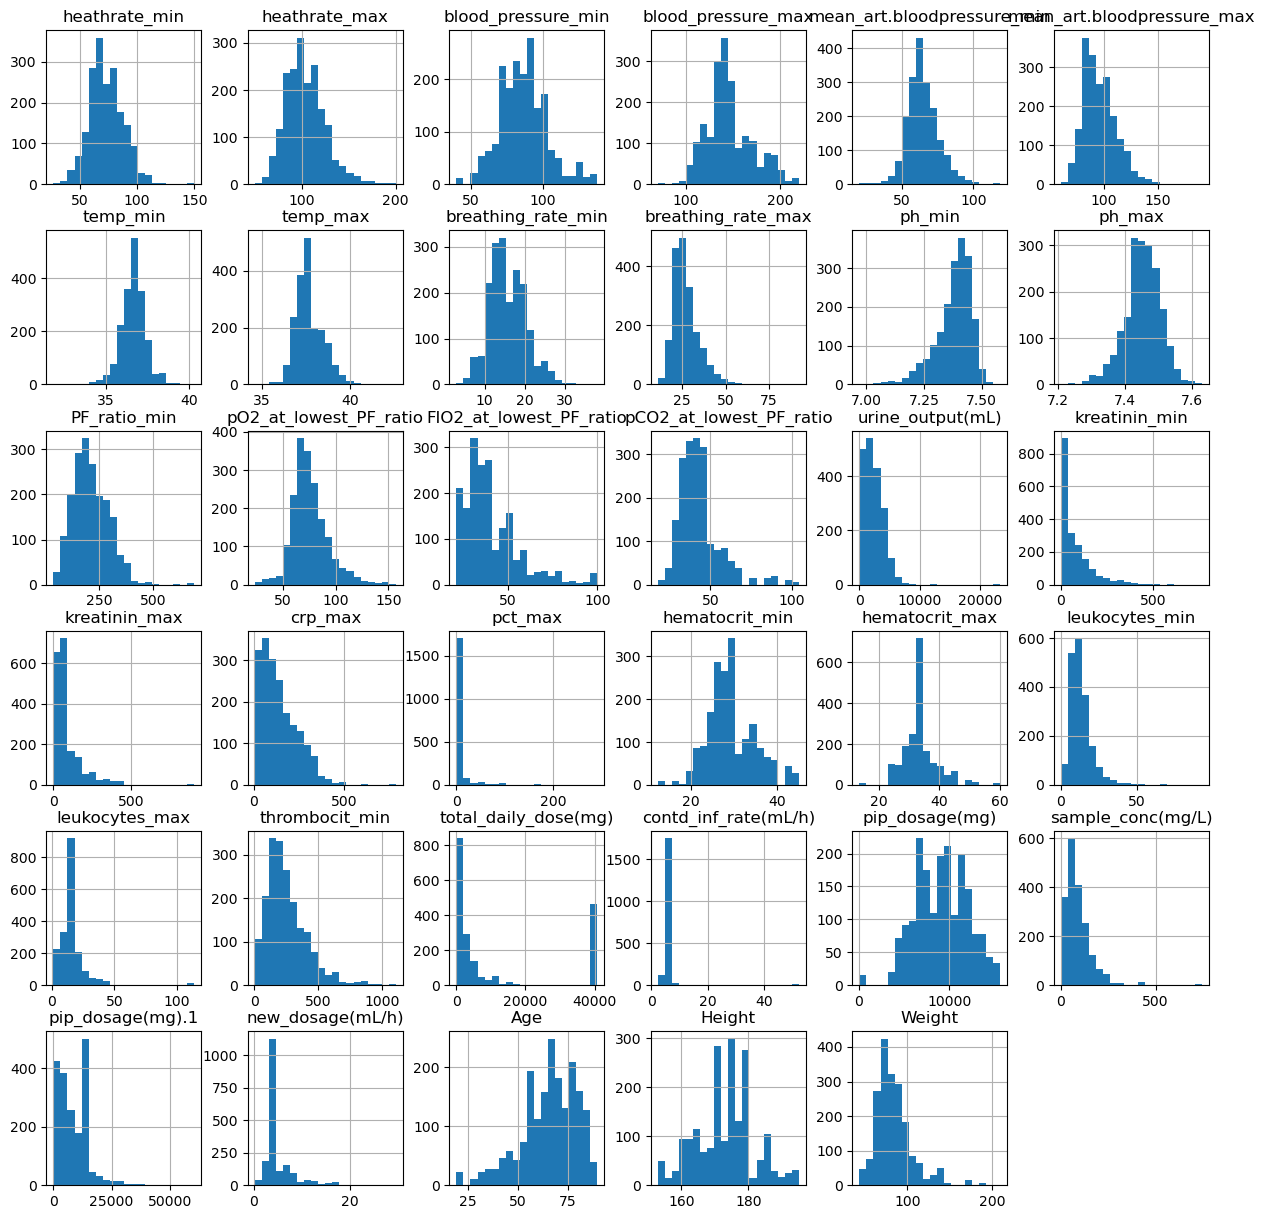

In [49]:
train_X.hist(bins=20, figsize=(15,15))
plt.show()

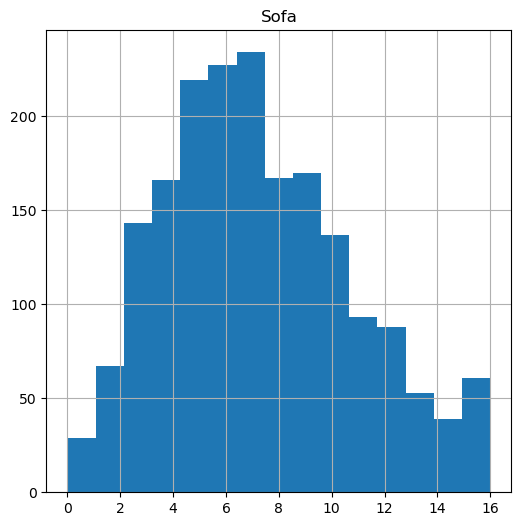

In [53]:
train_y.hist(bins=15, figsize=(6,6))
plt.show()

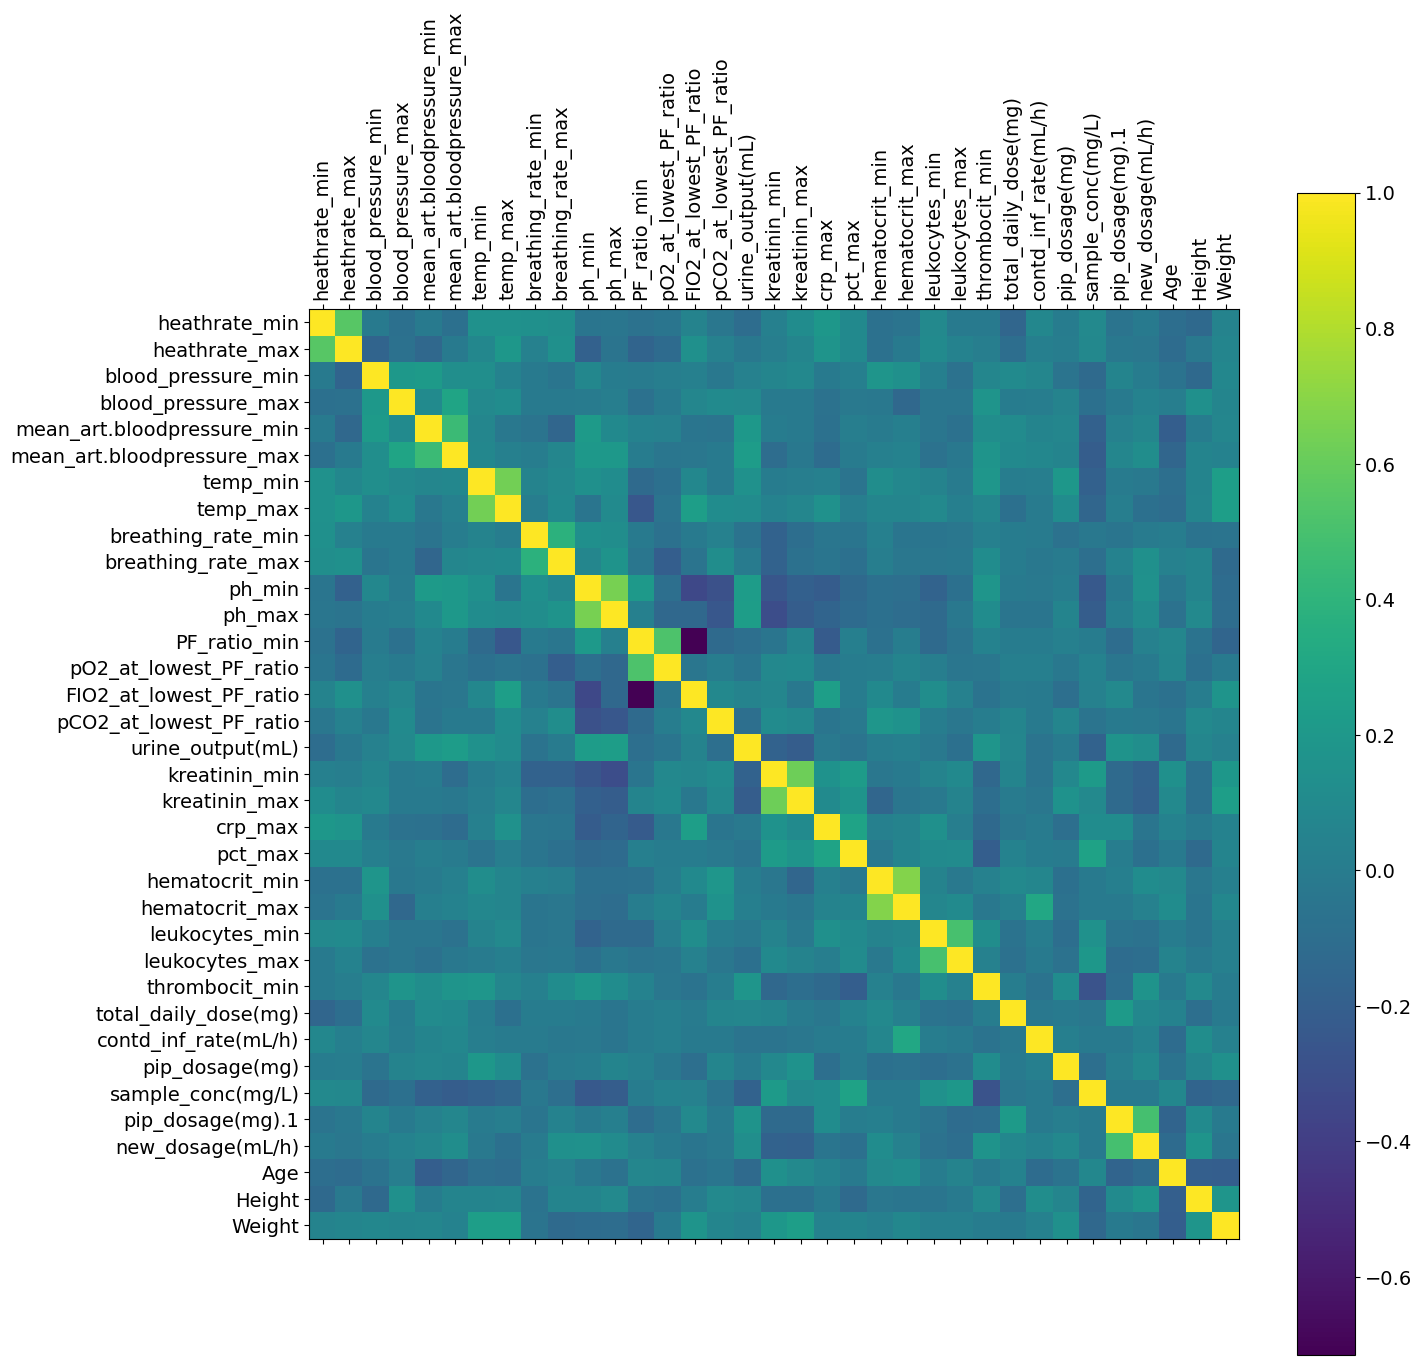

In [92]:
correlationMatrix = train_X.corr() 
f = plt.figure(figsize=(15, 15))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(train_X.shape[1]), train_X.columns, fontsize=14, rotation=90)
plt.yticks(range(train_X.shape[1]), train_X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

# Standard Scaling

In [59]:
train = pd.concat([train_X, train_y], axis=1)
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
train_scaled = pd.DataFrame(train_scaled, columns = train.columns)
train_X = train_scaled.drop(columns = ['Sofa'])
train_y = train_scaled[['Sofa']]

# Feature Selection GA

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.806913  1.        0.067109]	[ 0.022394  0.        0.013493]	[-0.846807  1.        0.048405]	[-0.730982  1.        0.114282]
1  	79    	[-2182.430325     1.066667  2181.874054]	[ 4129.791783     0.562821  4130.085645]	[-10000.            0.            0.048405]	[   -0.730982     4.       10000.      ]
2  	96    	[-2546.02473      1.084848  2545.512851]	[ 4355.720832     0.682296  4356.019948]	[-10000.            0.            0.048405]	[   -0.730982     5.       10000.      ]
3  	82    	[-2061.202008     1.054545  2060.666419]	[ 4044.441536     0.595483  4044.714393]	[-10000.            0.            0.048405]	[   -0.730982     4.       10000.      ]
4  	94    	[-2303.597118     1.072727  2303.08793 ]	[ 4209.957691     0.637834  4210.236219]	[-10000.            0.            0.048405]	[   -0.7

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.803493  1.551515  0.067619]	[ 0.028466  0.497339  0.015357]	[-0.856129  1.        0.041979]	[-0.723917  2.        0.131198]
1  	83    	[-1576.412665     1.666667  1575.817512]	[ 3643.144161     0.749411  3643.401561]	[-10000.            0.            0.041979]	[   -0.712788     4.       10000.      ]
2  	109   	[-1697.595227     1.690909  1697.031651]	[ 3753.380861     0.842926  3753.635644]	[-10000.            0.            0.046146]	[   -0.669452     5.       10000.      ]
3  	102   	[-1939.987894     1.745455  1939.455627]	[ 3953.528399     0.963922  3953.789482]	[-10000.            0.            0.046146]	[   -0.669452     7.       10000.      ]
4  	77    	[-1091.553614     1.8       1090.978574]	[ 3117.306864     0.698049  3117.508086]	[-10000.            0.            0.049189]	[   -0.6

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.792994  2.048485  0.072193]	[ 0.033088  0.822458  0.017645]	[-0.856639  1.        0.044338]	[-0.691413  3.        0.126935]
1  	93    	[-1030.989403     2.321212  1030.371175]	[ 3039.751911     1.008977  3039.961439]	[-10000.           0.           0.03872]	[   -0.691413     5.       10000.      ]
2  	91    	[-727.958636    2.363636  727.345074]   	[ 2596.690972     0.960372  2596.862804]	[-10000.            0.            0.044359]	[   -0.661135     5.       10000.      ]
3  	96    	[-970.344651    2.557576  969.771852]   	[ 2958.952758     0.955694  2959.140459]	[-10000.            1.            0.048405]	[   -0.654367     6.       10000.      ]
4  	72    	[-1152.134298     2.769697  1151.594633]	[ 3191.823696     0.850128  3192.018378]	[-10000.            0.            0.054002]	[   -0.6543

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.790973  2.509091  0.075139]	[ 0.034689  1.136812  0.019356]	[-0.856129  1.        0.042912]	[-0.654367  4.        0.138374]
1  	70    	[-909.780257    2.866667  909.162485]	[ 2874.579882     1.286448  2874.775239]	[-10000.            0.            0.043575]	[   -0.654367     7.       10000.      ]
2  	81    	[-970.353323    3.175758  969.769601]	[ 2958.949916     1.180403  2959.141197]	[-10000.            0.            0.048366]	[   -0.654367     6.       10000.      ]
3  	86    	[-970.331358    3.387879  969.770905]	[ 2958.957113     1.059376  2959.14077 ]	[-10000.           1.           0.04833]   	[   -0.638904     7.       10000.      ]
4  	83    	[-727.902572    3.557576  727.349923]	[ 2596.706673     0.968294  2596.861446]	[-10000.            2.            0.048465]	[   -0.638904    11.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.783563  2.830303  0.076978]	[ 0.037726  1.425415  0.021585]	[-0.853777  1.        0.037598]	[-0.682593  5.        0.138284]
1  	87    	[-849.168552    3.581818  848.562051]	[ 2786.352771     1.568913  2786.537446]	[-10000.            0.            0.040631]	[   -0.651862     8.       10000.      ]
2  	94    	[-1030.949188     3.975758  1030.376638]	[ 3039.765541     1.435276  3039.959587]	[-10000.            1.            0.032635]	[   -0.648545     7.       10000.      ]
3  	76    	[-909.725208    4.127273  909.166235]   	[ 2874.59729      1.260897  2874.774053]	[-10000.            1.            0.032635]	[   -0.636777     8.       10000.      ]
4  	83    	[-1394.52225      4.345455  1394.01108 ]	[ 3463.336834     1.16855   3463.542558]	[-10000.            2.            0.032635]	[   -0.6361

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.778693  3.412121  0.077166]	[ 0.040905  1.768368  0.022366]	[-0.856129  1.        0.023775]	[-0.638185  6.        0.140408]
1  	91    	[-485.555977    4.127273  484.925982]	[ 2147.724556     1.765541  2147.866767]	[-10000.            1.            0.023775]	[   -0.638185     9.       10000.      ]
2  	95    	[-1091.545057     4.563636  1090.982788]	[ 3117.309858     1.745265  3117.506611]	[-10000.            0.            0.043496]	[   -0.630203     9.       10000.      ]
3  	71    	[-303.69746     4.618182  303.109611]   	[ 1714.08032      1.454242  1714.184238]	[-10000.            1.            0.048361]	[   -0.627685     9.       10000.      ]
4  	94    	[-788.491781    5.193939  787.957677]   	[ 2693.894764     1.210544  2694.050962]	[-10000.            2.            0.047679]	[   -0.6276

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.771883  3.909091  0.078132]	[ 0.044298  1.999449  0.023299]	[-0.855891  1.        0.033957]	[-0.655231  7.        0.161147]
1  	87    	[-364.34412     4.921212  363.715661]	[ 1871.795267     1.957078  1871.917349]	[-10000.            1.            0.033957]	[   -0.655231    10.       10000.      ]
2  	91    	[-849.126131    5.375758  848.56172 ]	[ 2786.365688     1.836834  2786.537547]	[-10000.            1.            0.033957]	[   -0.637285    13.       10000.      ]
3  	82    	[-303.686446    4.866667  303.109146]	[ 1714.082267     1.515709  1714.18432 ]	[-10000.            1.            0.033957]	[   -0.630554     9.       10000.      ]
4  	98    	[-485.475569    4.848485  484.927617]	[ 2147.742707     1.61285   2147.866398]	[-10000.            1.            0.051612]	[   -0.610869    10.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.770597  4.587879  0.083685]	[ 0.045491  2.371518  0.023537]	[-0.852227  1.        0.035084]	[-0.65882   8.        0.145069]
1  	77    	[-303.736007    5.775758  303.115102]	[ 1714.073506     1.759309  1714.183267]	[-10000.            1.            0.035084]	[   -0.653674    10.       10000.      ]
2  	77    	[-909.728458    6.206061  909.171482]	[ 2874.596263     1.905326  2874.772393]	[-10000.           1.           0.04487]   	[   -0.624984    14.       10000.      ]
3  	85    	[-606.697752    6.157576  606.14355 ]	[ 2385.901157     1.73363   2386.041924]	[-10000.            2.            0.049963]	[   -0.624984    11.       10000.      ]
4  	84    	[-243.063825    5.975758  242.512889]	[ 1537.908587     1.509371  1537.995426]	[-10000.          2.          0.0513]      	[   -0.613952    11.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.767903  4.787879  0.083787]	[ 0.044063  2.630331  0.024832]	[-0.83673   1.        0.041091]	[-0.630987  9.        0.148797]
1  	80    	[-364.34106     5.957576  363.721962]	[ 1871.795861     2.561608  1871.916125]	[-10000.            1.            0.038717]	[   -0.630987    11.       10000.      ]
2  	85    	[-485.517022    6.818182  484.940073]	[ 2147.73335      2.230023  2147.863586]	[-10000.           1.           0.04689]   	[   -0.630987    12.       10000.      ]
3  	87    	[-485.491739    7.315152  484.94088 ]	[ 2147.739057     1.861267  2147.863404]	[-10000.            2.            0.048659]	[   -0.623213    11.       10000.      ]
4  	72    	[-606.676678    7.575758  606.151175]	[ 2385.90651      1.633555  2386.039988]	[-10000.            3.            0.055304]	[   -0.6168    11.  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.758209  5.6       0.08832 ]	[ 0.051766  2.916619  0.027588]	[-0.846991  1.        0.040349]	[-0.63341  10.        0.172062]
1  	97    	[-667.337727    6.842424  666.755929]	[ 2494.25891      2.598255  2494.414402]	[-10000.            1.            0.045217]	[   -0.63341    13.      10000.     ]
2  	93    	[-424.901331    7.224242  424.334249]	[ 2015.41151      2.069553  2015.530872]	[-10000.            2.            0.050664]	[   -0.619478    13.       10000.      ]
3  	90    	[-485.481044    7.587879  484.94172 ]	[ 2147.741471     1.978637  2147.863214]	[-10000.            2.            0.045737]	[   -0.619478    12.       10000.      ]
4  	96    	[-364.259145    8.018182  363.730469]	[ 1871.811773     1.616104  1871.914472]	[-10000.            3.            0.051995]	[   -0.613184    12.       10000.      ]
5  	86    	[-788.463539  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.754778  5.89697   0.083528]	[ 0.048854  3.267145  0.0252  ]	[-0.847444  1.        0.041554]	[-0.644098 11.        0.169591]
1  	90    	[-303.723195    7.345455  303.113688]	[ 1714.075771     2.849039  1714.183517]	[-10000.            1.            0.037201]	[   -0.638736    14.       10000.      ]
2  	90    	[-364.291905    8.563636  363.722377]	[ 1871.80541      2.089776  1871.916044]	[-10000.            3.            0.041183]	[   -0.610896    13.       10000.      ]
3  	87    	[-727.882786    9.169697  727.358586]	[ 2596.712214     1.844317  2596.85902 ]	[-10000.            4.            0.053825]	[   -0.610896    15.       10000.      ]
4  	85    	[-546.061423    9.024242  545.542576]	[ 2270.762596     1.815594  2270.887219]	[-10000.            4.            0.054681]	[   -0.610896    13.       10000.      ]
5  	88    	[-667.25360

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.751896  6.757576  0.087434]	[ 0.047672  3.434498  0.025421]	[-0.847496  1.        0.036069]	[-0.623246 12.        0.163534]
1  	76    	[-364.319575    8.315152  363.727826]	[ 1871.800034     3.038752  1871.914986]	[-10000.            1.            0.031853]	[   -0.623246    15.       10000.      ]
2  	86    	[-364.296233    9.145455  363.727281]	[ 1871.804569     2.491816  1871.915092]	[-10000.          2.          0.0443]      	[   -0.623246    14.       10000.      ]
3  	79    	[-364.278076    9.854545  363.724447]	[ 1871.808096     2.083862  1871.915642]	[-10000.            3.            0.047628]	[   -0.623144    15.       10000.      ]
4  	101   	[-788.476782   10.048485  787.959385]	[ 2693.89915      1.887137  2694.050462]	[-10000.            6.            0.050769]	[   -0.607696    15.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.754162  6.909091  0.085148]	[ 0.054041  3.595988  0.024099]	[-0.858038  1.        0.040507]	[-0.639048 13.        0.136072]
1  	89    	[-182.515795    8.666667  181.903751]	[ 1335.990382     3.023811  1336.07367 ]	[-10000.            1.            0.028913]	[   -0.626593    15.       10000.      ]
2  	86    	[-303.690538    9.490909  303.118229]	[ 1714.081544     2.281993  1714.182714]	[-10000.            3.            0.028913]	[   -0.619723    15.       10000.      ]
3  	101   	[-364.268717    9.557576  363.722351]	[ 1871.809914     2.286592  1871.916049]	[-10000.            5.            0.049222]	[   -0.613442    15.       10000.      ]
4  	74    	[-182.445064    9.612121  181.904972]	[ 1336.000007     2.164697  1336.073504]	[-10000.            5.            0.050609]	[   -0.610153    15.       10000.      ]
5  	59    	[-61.230307

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.749062  7.412121  0.093226]	[ 0.046136  3.702559  0.027891]	[-0.850222  1.        0.037996]	[-0.648701 14.        0.167339]
1  	80    	[-182.513999    9.454545  181.917329]	[ 1335.990626     2.975566  1336.071822]	[-10000.            1.            0.048405]	[   -0.63757    19.      10000.     ]
2  	83    	[-182.48337    10.315152  181.919951]	[ 1335.994794     2.434116  1336.071465]	[-10000.            5.            0.053831]	[   -0.635512    16.       10000.      ]
3  	88    	[-182.466136   10.29697   181.918802]	[ 1335.997139     2.377226  1336.071622]	[-10000.            5.            0.046001]	[   -0.620839    15.       10000.      ]
4  	85    	[-61.247905   9.70303   60.696993]   	[ 776.086152    2.07503   776.129171]   	[-10000.            6.            0.043709]	[   -0.619159    16.   

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.744016  7.727273  0.088973]	[ 0.05137   4.498301  0.026614]	[-0.848361  1.        0.042734]	[-0.614805 15.        0.189694]
1  	69    	[-61.30833    9.848485  60.695369]	[ 776.081434    3.866885  776.129298]	[-10000.            2.            0.039865]	[   -0.614805    18.       10000.      ]
2  	95    	[-606.696109   11.115152  606.141198]	[ 2385.901574     3.395909  2386.042522]	[-10000.            2.            0.037392]	[   -0.608394    19.       10000.      ]
3  	98    	[-243.066503   11.50303   242.507493]	[ 1537.908165     2.519317  1537.996277]	[-10000.            3.            0.036961]	[   -0.608394    18.       10000.      ]
4  	91    	[-303.647823   11.787879  303.111338]	[ 1714.089094     2.142748  1714.183932]	[-10000.            6.            0.036961]	[   -0.603705    19.      

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.741363  8.09697   0.090214]	[ 0.054468  4.545026  0.027215]	[-0.840212  1.        0.041458]	[-0.608104 16.        0.154125]
1  	97    	[-121.895356   10.624242  121.307475]	[ 1094.195233     3.424248  1094.260352]	[-10000.            2.            0.038101]	[   -0.608104    18.       10000.      ]
2  	84    	[-61.258671  12.127273  60.700972]   	[ 776.085311    2.264786  776.12886 ]   	[-10000.            4.            0.061466]	[   -0.608104    19.       10000.      ]
3  	96    	[-0.637912 12.521212  0.08688 ]      	[ 0.019008  2.244422  0.014926]         	[-0.764217  5.        0.045852]            	[-0.608104 16.        0.128579]         
4  	84    	[-546.045828   13.357576  545.53169 ]	[ 2270.766342     2.309274  2270.889833]	[-10000.           8.           0.05257]   	[   -0.600693    19.       10000.      ]
5  	67    	[-303.62898

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.743453  8.581818  0.09145 ]	[ 0.051127  4.744468  0.024729]	[-0.855606  1.        0.03275 ]	[-0.622645 17.        0.150846]
1  	78    	[-121.899632   11.133333  121.307254]	[ 1094.194759     3.974972  1094.260377]	[-10000.            1.            0.041282]	[   -0.622645    19.       10000.      ]
2  	91    	[-424.88082    12.757576  424.333851]	[ 2015.415827     3.227066  2015.530956]	[-10000.            3.            0.039502]	[   -0.614721    20.       10000.      ]
3  	68    	[-303.657272   13.442424  303.117183]	[ 1714.087424     2.809834  1714.182899]	[-10000.            6.            0.039502]	[   -0.604954    20.       10000.      ]
4  	93    	[-364.245735   13.593939  363.722322]	[ 1871.814378     2.337823  1871.916055]	[-10000.            6.            0.039502]	[   -0.604954    19.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.743599  9.460606  0.090651]	[ 0.054622  5.103174  0.025394]	[-0.835547  1.        0.032698]	[-0.612987 18.        0.152453]
1  	70    	[-121.900407   12.49697   121.309251]	[ 1094.194674     3.843332  1094.260155]	[-10000.            1.            0.032698]	[   -0.612987    19.       10000.      ]
2  	91    	[-121.863776   13.842424  121.309263]	[ 1094.198731     2.906527  1094.260154]	[-10000.            6.            0.057737]	[   -0.611542    20.       10000.      ]
3  	92    	[-182.442603   13.757576  181.910534]	[ 1336.000341     2.815867  1336.072747]	[-10000.            7.            0.054156]	[   -0.603727    20.       10000.      ]
4  	83    	[-182.428404   13.8       181.904199]	[ 1336.002274     2.44007   1336.073609]	[-10000.            8.            0.056811]	[   -0.603727    19.       10000.      ]
5  	89    	[-243.02358

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.727172 10.551515  0.093058]	[ 0.05219   5.553493  0.025866]	[-0.84355   1.        0.037312]	[-0.628452 19.        0.142656]
1  	77    	[-121.889474   13.248485  121.307519]	[ 1094.195885     4.465906  1094.260347]	[-10000.           1.           0.03944]	[   -0.617075    20.       10000.      ]
2  	80    	[-182.46499    13.89697   181.909128]	[ 1335.997295     3.414096  1336.072938]	[-10000.            6.            0.036179]	[   -0.606521    22.       10000.      ]
3  	104   	[-121.845301   13.927273  121.301632]	[ 1094.200777     3.118981  1094.260999]	[-10000.            8.            0.036179]	[   -0.606521    20.       10000.      ]
4  	81    	[-121.833573   14.072727  121.297159]	[ 1094.202076     2.992037  1094.261495]	[-10000.           7.           0.04369]   	[   -0.604595    21.   

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.733873 10.678788  0.091727]	[ 0.056115  5.902221  0.026758]	[-0.857164  1.        0.032972]	[-0.634625 20.        0.152107]
1  	90    	[-121.889128   13.466667  121.30331 ]	[ 1094.195923     3.896437  1094.260814]	[-10000.            2.            0.028215]	[   -0.612006    23.       10000.      ]
2  	81    	[-243.063181   14.866667  242.510539]	[ 1537.908688     3.19001   1537.995797]	[-10000.           6.           0.03584]   	[   -0.604633    22.       10000.      ]
3  	88    	[-121.8418     14.648485  121.294207]	[ 1094.201165     2.623451  1094.261822]	[-10000.            7.            0.045361]	[   -0.600075    21.       10000.      ]
4  	91    	[-0.625277 14.533333  0.078397]      	[ 0.012546  2.347231  0.012462]         	[-0.673883  9.        0.04253 ]            	[-0.600075 20.        0.115423]         
5  	90    	[-0.615263 

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.726362 11.466667  0.096781]	[ 0.053752  6.356608  0.027517]	[-0.867819  1.        0.033965]	[-0.617415 21.        0.151117]
1  	95    	[-0.683805 13.909091  0.098152]	[ 0.040751  4.404981  0.024391]	[-0.813044  2.        0.037855]	[-0.614025 21.        0.14869 ]
2  	85    	[-121.856676   15.739394  121.306693]	[ 1094.199517     3.543491  1094.260439]	[-10000.            3.            0.054844]	[   -0.608124    22.       10000.      ]
3  	75    	[-121.840818   16.351515  121.300967]	[ 1094.201274     3.066547  1094.261073]	[-10000.            8.            0.041159]	[   -0.605443    22.       10000.      ]
4  	87    	[-121.828917   16.830303  121.294174]	[ 1094.202592     2.780068  1094.261825]	[-10000.           9.           0.05106]   	[   -0.602297    24.       10000.      ]
5  	94    	[-121.820143   17.115152  121.289582]	[ 1094.20

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.725133 11.333333  0.095643]	[ 0.056652  6.208824  0.026606]	[-0.846814  1.        0.041642]	[-0.622162 22.        0.159139]
1  	88    	[-182.479489   13.993939  181.916764]	[ 1335.995322     5.341089  1336.071899]	[-10000.            3.            0.045045]	[   -0.622162    25.       10000.      ]
2  	84    	[-121.851375   15.042424  121.305926]	[ 1094.200104     4.128763  1094.260524]	[-10000.            3.            0.047893]	[   -0.614665    24.       10000.      ]
3  	86    	[-121.83569    15.612121  121.302251]	[ 1094.201842     3.706813  1094.260931]	[-10000.            7.            0.047893]	[   -0.603333    24.       10000.      ]
4  	92    	[-61.227045  15.533333  60.693589]   	[ 776.087781    3.182401  776.129437]   	[-10000.            7.            0.038096]	[   -0.601374    24.       10000.      ]
5  	78    	[-0.618933 

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.724894 11.442424  0.090051]	[ 0.058316  6.285483  0.023134]	[-0.853757  1.        0.04135 ]	[-0.606933 23.        0.144533]
1  	88    	[-61.280087  14.957576  60.697877]	[ 776.083639    5.014345  776.129102]	[-10000.           2.           0.04135]	[   -0.606933    24.       10000.      ]
2  	73    	[-61.250542  16.812121  60.692437]	[ 776.085946    3.922874  776.129527]	[-10000.            6.            0.040558]	[   -0.604643    24.       10000.      ]
3  	91    	[-182.435525   18.569697  181.898466]	[ 1336.001305     3.212144  1336.074389]	[-10000.           10.            0.049087]	[   -0.599095    25.       10000.      ]
4  	92    	[-182.422882   19.781818  181.892092]	[ 1336.003025     2.5276    1336.075256]	[-10000.          14.           0.04501]   	[   -0.599095    25.       10000.  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.721288 12.660606  0.094948]	[ 0.05439   6.835289  0.027393]	[-0.851198  1.        0.041514]	[-0.617624 24.        0.153652]
1  	68    	[-61.280006  16.854545  60.707236]	[ 776.083646    5.207517  776.128371]	[-10000.            2.            0.043074]	[   -0.616288    26.       10000.      ]
2  	85    	[-0.651544 18.193939  0.100712]   	[ 0.023268  4.080845  0.021415]      	[-0.747832  2.        0.043074]            	[-0.611987 24.        0.143695]         
3  	91    	[-303.64597    19.260606  303.118576]	[ 1714.089422     3.651313  1714.182653]	[-10000.          10.           0.04374]   	[   -0.606312    27.       10000.      ]
4  	98    	[-243.031801   19.309091  242.508966]	[ 1537.913634     3.216658  1537.996045]	[-10000.           11.            0.056308]	[   -0.597053    27.       10000.      ]
5  	81    	[-121.820515   19.21818

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.711667 12.678788  0.095406]	[ 0.053121  6.963966  0.023519]	[-0.836504  1.        0.037601]	[-0.627298 25.        0.160442]
1  	84    	[-121.873127   15.824242  121.309328]	[ 1094.197695     5.581302  1094.260147]	[-10000.            2.            0.045668]	[   -0.616425    28.       10000.      ]
2  	87    	[-0.646657 17.206061  0.097925]      	[ 0.017724  4.314173  0.014535]         	[-0.711348  6.        0.062474]            	[-0.613604 25.        0.147936]         
3  	79    	[-121.838529   18.163636  121.305935]	[ 1094.201527     3.417053  1094.260523]	[-10000.            8.            0.064303]	[   -0.601579    27.       10000.      ]
4  	106   	[-0.625704 18.30303   0.08779 ]      	[ 0.011471  3.208746  0.011579]         	[-0.665547  8.        0.057536]            	[-0.601067 25.      

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.719049 12.727273  0.09411 ]	[ 0.057522  6.809408  0.025154]	[-0.848361  1.        0.038549]	[-0.616554 26.        0.162571]
1  	80    	[-0.672736 17.266667  0.099872]	[ 0.03043   4.410914  0.020081]	[-0.785893  3.        0.053761]	[-0.61211  26.        0.149962]
2  	87    	[-0.648112 18.757576  0.09546 ]	[ 0.019473  3.753223  0.018847]	[-0.702673  5.        0.037015]	[-0.606004 25.        0.13506 ]
3  	71    	[-0.632595 18.581818  0.086983]	[ 0.014169  2.97275   0.01444 ]	[-0.673156  9.        0.050713]	[-0.606004 26.        0.125238]
4  	94    	[-0.622679 18.4       0.082701]	[ 0.01133   2.651015  0.011636]	[-0.667727 12.        0.051056]	[-0.602795 25.        0.112323]
5  	80    	[-0.616097 18.012121  0.080315]	[ 0.009153  2.847621  0.009875]	[-0.668641 12.        0.049896]	[-0.599914 25.  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.717923 13.139394  0.094906]	[ 0.057201  7.796578  0.024893]	[-0.851972  1.        0.04216 ]	[-0.624399 27.        0.168609]
1  	88    	[-243.079907   17.515152  242.519404]	[ 1537.906052     6.346181  1537.994399]	[-10000.           2.           0.04216]	[   -0.619631    29.       10000.      ]
2  	73    	[-61.249996  19.939394  60.703317]   	[ 776.085989    4.411688  776.128677]   	[-10000.            8.            0.049191]	[   -0.610405    29.       10000.      ]
3  	91    	[-61.23651   20.4       60.696665]   	[ 776.087042    4.0359    776.129196]   	[-10000.            8.            0.049191]	[   -0.605618    28.       10000.      ]
4  	95    	[-61.226681  20.163636  60.689621]   	[ 776.087809    3.89917   776.129746]   	[-10000.            8.            0.047142]	[   -0.605618    30.       10000.      ]
5  	101   	[-0.618084 19.

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.717735 14.527273  0.097239]	[ 0.056695  8.245891  0.024922]	[-0.853757  1.        0.035248]	[-0.609684 28.        0.159019]
1  	80    	[-182.471924   21.393939  181.920296]	[ 1335.996352     5.078412  1336.071418]	[-10000.            4.            0.045805]	[   -0.609684    30.       10000.      ]
2  	86    	[-61.244502  22.818182  60.706093]   	[ 776.086417    3.089126  776.12846 ]   	[-10000.            7.            0.068312]	[   -0.609684    29.       10000.      ]
3  	91    	[-61.231312  22.515152  60.696367]   	[ 776.087447    2.45346   776.12922 ]   	[-10000.           17.            0.065201]	[   -0.607979    29.       10000.      ]
4  	83    	[-0.618849 22.10303   0.081331]      	[ 0.009015  1.857415  0.010947]         	[-0.672767 17.        0.058429]            	[-0.600235 27.      

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.711559 14.690909  0.097865]	[ 0.05251   8.028448  0.024131]	[-0.834093  1.        0.041607]	[-0.615067 29.        0.169672]
1  	93    	[-0.667963 19.642424  0.100218]	[ 0.034122  6.154527  0.018785]	[-0.788858  5.        0.052442]	[-0.615067 29.        0.141138]
2  	78    	[-0.64221  22.284848  0.096867]	[ 0.017887  4.393944  0.016331]	[-0.7193    9.        0.049939]	[-0.610718 29.        0.140385]
3  	79    	[-61.233902  23.187879  60.695742]	[ 776.087245    3.644153  776.129268]	[-10000.           14.            0.049939]	[   -0.608169    30.       10000.      ]
4  	89    	[-0.625274 23.709091  0.08419 ]   	[ 0.00968   2.960381  0.015428]      	[-0.668839 16.        0.051627]            	[-0.606544 29.        0.116861]         
5  	83    	[-0.619896 23.30303   0.077774]   	[ 0.007967  2.825

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.704119 16.10303   0.099436]	[ 0.052737  8.267955  0.023751]	[-0.857869  1.        0.046612]	[-0.621285 30.        0.145416]
1  	104   	[-0.661446 20.678788  0.100152]	[ 0.024034  5.620296  0.020423]	[-0.763897  5.        0.049499]	[-0.621285 30.        0.150023]
2  	89    	[-0.643101 21.551515  0.093444]	[ 0.013401  4.298564  0.01716 ]	[-0.689927 10.        0.057762]	[-0.616601 30.        0.132201]
3  	85    	[-0.632483 22.139394  0.090659]	[ 0.011415  3.868908  0.016473]	[-0.677334 11.        0.055371]	[-0.605798 30.        0.128867]
4  	75    	[-0.623513 21.206061  0.085078]	[ 0.008562  3.630672  0.014411]	[-0.646792 14.        0.050476]	[-0.603678 29.        0.120868]
5  	92    	[-0.618477 20.139394  0.082868]	[ 0.009587  3.260223  0.011558]	[-0.671845 14.        0.057748]	[-0.59428  28.  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.712539 14.812121  0.096692]	[ 0.055317  8.903923  0.023304]	[-0.825859  1.        0.045313]	[-0.624647 31.        0.162347]
1  	77    	[-61.267182  21.151515  60.70685 ]	[ 776.084647    6.249951  776.128401]	[-10000.            7.            0.045313]	[   -0.616529    32.       10000.      ]
2  	85    	[-0.645048 24.012121  0.099952]   	[ 0.014581  4.383147  0.016719]      	[-0.700143 10.        0.051946]            	[-0.616529 31.        0.138357]         
3  	93    	[-61.23578   24.254545  60.700612]	[ 776.087098    3.859117  776.128888]	[-10000.          13.           0.05576]   	[   -0.610982    32.       10000.      ]
4  	84    	[-0.624833 23.836364  0.087697]   	[ 0.008548  3.314415  0.013998]      	[-0.663052 13.        0.05576 ]            	[-0.606688 29.        0.130438]         
5  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.708321 16.963636  0.099144]	[ 0.057196  9.2513    0.024925]	[-0.847698  1.        0.043896]	[-0.610356 32.        0.170221]
1  	81    	[-61.264366  23.169697  60.708652]	[ 776.084867    5.883335  776.12826 ]	[-10000.            1.            0.060032]	[   -0.604451    34.       10000.      ]
2  	83    	[-0.641802 24.757576  0.094242]   	[ 0.016178  4.424658  0.017031]      	[-0.703473 15.        0.05335 ]            	[-0.604451 32.        0.141887]         
3  	74    	[-61.233574  24.048485  60.69347 ]	[ 776.087271    3.924756  776.129446]	[-10000.           15.            0.050105]	[   -0.604451    33.       10000.      ]
4  	78    	[-0.621602 22.6       0.081958]   	[ 0.009608  3.33721   0.010293]      	[-0.655518 14.        0.056705]            	[-0.604451 31.        0.108801]         
5  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.699293 17.860606  0.099864]	[ 0.051632  9.310077  0.023564]	[-0.847698  1.        0.038903]	[-0.617816 33.        0.154183]
1  	77    	[-61.259887  23.654545  60.708253]	[ 776.085216    5.925451  776.128292]	[-10000.            4.            0.052336]	[   -0.617816    34.       10000.      ]
2  	97    	[-0.63818  25.193939  0.095764]   	[ 0.012929  3.731759  0.016614]      	[-0.682789 10.        0.062642]            	[-0.607776 33.        0.13417 ]         
3  	95    	[-0.630103 24.236364  0.0887  ]   	[ 0.011421  3.050864  0.015077]      	[-0.703932 17.        0.059189]            	[-0.607776 32.        0.138468]         
4  	89    	[-0.623965 22.878788  0.082608]   	[ 0.009575  2.583838  0.012113]      	[-0.673303 17.        0.055252]            	[-0.606838 30.        0.112618]         
5  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	165   	[-0.702138 17.109091  0.098726]	[ 0.053858  9.494508  0.023726]	[-0.845242  1.        0.025963]	[-0.618972 34.        0.159552]
1  	93    	[-61.264201  22.678788  60.706584]	[ 776.084879    6.453552  776.128422]	[-10000.            8.            0.045697]	[   -0.618972    35.       10000.      ]
2  	82    	[-0.642321 23.29697   0.094546]   	[ 0.016637  5.20166   0.015693]      	[-0.691278 10.        0.046715]            	[-0.613577 34.        0.128239]         
3  	68    	[-0.629295 22.878788  0.085921]   	[ 0.010033  4.552439  0.012824]      	[-0.656353 10.        0.062138]            	[-0.607087 34.        0.125741]         
4  	81    	[-0.620232 21.612121  0.078656]   	[ 0.007932  3.766821  0.011206]      	[-0.649537 15.        0.06013 ]            	[-0.603575 29.        0.120726]         
5  

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-0.701616 18.127273  0.09633 ]	[  0.052601  10.606552   0.023035]	[-0.827203  1.        0.038316]	[-0.625315 35.        0.161656]
1  	91    	[-0.659447 25.648485  0.099868]	[ 0.023579  7.153559  0.017786]   	[-0.786937  4.        0.045204]	[-0.618956 35.        0.158682]
2  	83    	[-0.642857 28.072727  0.095743]	[ 0.011972  4.970902  0.015407]   	[-0.683402 10.        0.057365]	[-0.600276 35.        0.133046]
3  	78    	[-0.634961 27.606061  0.089798]	[ 0.011165  5.558174  0.014643]   	[-0.688315 10.        0.057365]	[-0.600276 34.        0.12375 ]
4  	83    	[-0.625125 24.757576  0.078115]	[ 0.00823   5.186406  0.014412]   	[-0.645958 10.        0.050059]	[-0.600276 33.        0.123348]
5  	73    	[-0.619128 21.927273  0.068827]	[ 0.007114  4.151033  0.011912]   	[-0.642528 11.        0.050

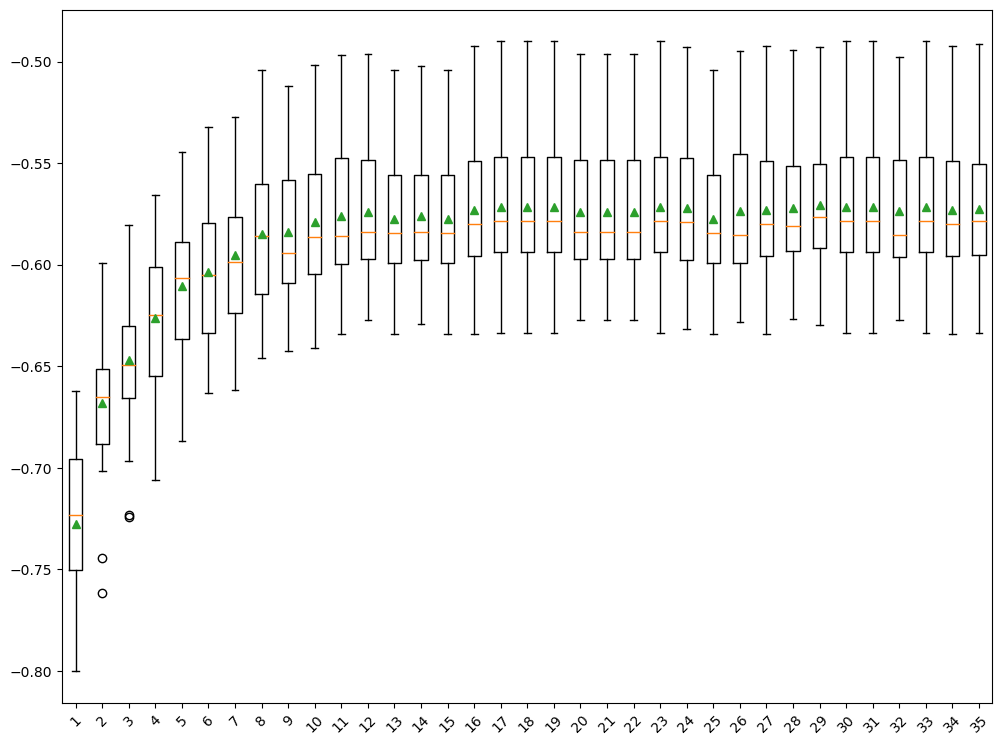

In [90]:
X = train_X
y = train_y
y = y.astype('float')
estimator = LinearRegression()
# evaluate the models and store results
results = []
names = []
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for i in range(1, len(train_X.columns) + 1):
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(LinearRegression(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

In [91]:
features_selected = ['mean_art.bloodpressure_min', 'ph_min', 'urine_output(mL)', 'leukocytes_min', 'thrombocit_min', 
                     'sample_conc(mg/L)', 'temp_min', 'temp_max', 'Weight', 'ph_max', 'PF_ratio_min', 
                     'pO2_at_lowest_PF_ratio', 'FIO2_at_lowest_PF_ratio']